In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch import device
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import sys
# !cp "/content/drive/MyDrive/Cours/ensta cours/CSC_5IA23_TA_Project-main/ResNet.py" ./ResNet.py
from ResNet import ResNet18
torch.manual_seed(47)
np.random.seed(47)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
tr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
data = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=tr
)
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)
val_data = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=tr
)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Neural Collapse

### separating the data per class

In [18]:
def load_model(path):
    d = torch.load(path)
    # d["cl.weight"] = d["model.13.weight"]
    # d["cl.bias"] = d["model.13.bias"]
    # d.pop("model.13.weight")
    # d.pop("model.13.bias")
    resnet = ResNet18(64,2,100).to(device)
    resnet.load_state_dict(d)
    return resnet
# resnet = load_model("/content/drive/MyDrive/Cours/ensta cours/model/resnet_360_epoch.pth")

In [19]:
def compute_features(resnet,dataloader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  resnet.eval()
  feats, labels_list, preds = [], [], []
  with torch.no_grad():
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = resnet.model(inputs)
        feats.append(out)
        labels_list.append(labels)
        preds.append(torch.argmax(resnet.cl(out),dim=1))
  W = resnet.cl.weight.data
  return torch.cat(feats,dim=0), torch.cat(labels_list,dim=0), W, torch.cat(preds,dim=0)


def get_mu_G(features):
  return torch.mean(features,dim=0).to(device)

def get_sigma_T(features,mu_G):
  t = features - mu_G
  t = t.T @ t / (features.shape[0])
  return t
  # return (features.T @ features) / (features.shape[0])

def get_sigma_B(mu_C_list,mu_G):
  sigma_B = torch.zeros((mu_G.shape[0],mu_G.shape[0]),device=device)
  for mu_C in mu_C_list:
    diff = mu_C - mu_G
    sigma_B += diff.unsqueeze(1) @ diff.unsqueeze(0) # Corrected outer product
  sigma_B /= len(mu_C_list)
  return sigma_B

def get_mu_C_list(features,labels):
  mu_C_list = []
  for i in range(100):
    mu_C_list.append(torch.mean(features[labels == i],dim=0).to(device))
  return mu_C_list

## NC 1

variability collapse : In class variations converges towards 0.
$$
\Sigma_B \to 0
$$
In practice we have
$$
Tr\big [ \frac {\Sigma_W \Sigma_B ^ † } C \big ]
$$



In [20]:
def nc1(sigma_W):
  return torch.linalg.norm(sigma_W)

def train_class_means_equinorm(mu_C_list,mu_G):
  centered_norms = []
  for key in range(len(mu_C_list)):
    centered_norms.append(torch.linalg.norm(mu_C_list[key] - mu_G))
  #Fig 2
  centered_norms = torch.tensor(centered_norms,device=device)
  return torch.std(centered_norms) / torch.mean(centered_norms)

def train_class_weights_equinorm(weights):
  norm = torch.linalg.norm(weights,dim=1)
  # print(norm.shape)
  # print(norm)
  #Fig 2
  m = torch.mean(norm)
  s = torch.std(norm)
  # print(m)
  # print(s)
  return  s/m

def scale_invariante_nc1(Sigma_W, Sigma_B,C=100):
    """
    Computes the NC1 metric: 1/C * Trace(Sigma_W * pinv(Sigma_B))
    """
    C = 100 # Number of classes
    Sigma_B_pinv = torch.linalg.pinv(Sigma_B, rcond=1e-6)
    # NC1 = 1/C * Trace(Sigma_W @ Sigma_B_pinv)
    nc1_value = torch.trace(Sigma_W @ Sigma_B_pinv) / float(C)

    #Fig 6
    return nc1_value.item()


## NC 2

As training progresses, the standard deviations of the cosines approach zero
indicating equiangularity

$$
\left| \|\mu_c - \mu_G\|_2 - \|\mu_{c'} - \mu_G\|_2 \right| \to 0 \quad \forall c, c'
$$
$$
    \langle \tilde{\mu}_c, \tilde{\mu}_{c'} \rangle \to \frac{C}{C-1} \delta_{c,c'} - \frac{1}{C-1} \quad \forall c, c'
$$
In practice we have
$$
EN_{\text{class-means}} = \frac{std_c\{ \|\mu_c - \mu_G\|_2 \}}{avg_c\{ \|\mu_c - \mu_G\|_2 \}}
$$

and
$$
\text{Equiangularity}_{\text{class-means}} = Avg_{c,c'} \big | \frac{ \langle {\mu}_c-{\mu}_G, {\mu}_{c'} - {\mu}_G \rangle  + \frac 1 {C-1} } {\|\mu_c - \mu_G\|_2\|\mu_c' - \mu_G\|_2}   \big |
$$


In [21]:
def nc2(mu_C_list,mu_G):
  C = len(mu_C_list)
  class_cos_sim = []
  for key in range(C):
    for key2 in range(key+1,C):
      norm=  (mu_C_list[key] -mu_G )@ (mu_C_list[key2] - mu_G)
      norm = norm/(torch.linalg.norm(mu_C_list[key] - mu_G)*torch.linalg.norm(mu_C_list[key2] - mu_G))
      class_cos_sim.append(norm)

  class_cos_sim = torch.tensor(class_cos_sim,device=device)
  vals_2 = torch.std(class_cos_sim)
  vals_3 = class_cos_sim + 1.0/(C - 1)
  vals_3 = torch.mean(vals_3)
  #Fig 3, Fig 4
  return vals_2,vals_3

def nc2_weights(weights):
  C = weights.shape[0]
  cosses = weights @ weights.T
  norms = torch.norm(weights, dim=1, keepdim=True)
  cosses = (weights @ weights.T) / (norms @ norms.T)
  cosses = cosses / norms
  #Fig 3, Fig 4
  #remove cos(x,x)
  mask = ~torch.eye(C, dtype=bool, device=weights.device)
  cosses = cosses[mask]
  vals_2 = torch.std(cosses)

  vals_3 = cosses + 1.0/(C - 1)
  vals_3 = torch.mean(vals_3)

  return vals_2,vals_3


## NC 3

 Convergence to self-duality:

$$ \left\| \frac{W^T}{\|W|_F} - \frac{\dot M}{\|\dot M|_F}\right\|_F \to 0$$


In [22]:
def nc3(mu_C_list,mu_G,W):
  mu_C_list = torch.stack(mu_C_list) - mu_G
  mu_C_list = mu_C_list / torch.linalg.norm(mu_C_list,dim=1,keepdim=True)

  W = W / torch.linalg.norm(W,dim=1,keepdim=True)

  #Fig 5
  return torch.linalg.norm(mu_C_list - W)**2

## NC 4
Simplification to NCC
$$ arg\max_{c'} \left< w_{c'}, h \right> + b_{c'} \to \arg\min_{c'} \|h - \mu_{c'}\|_2 $$


In [23]:
def compute_nc4_disagreement(features, mpred, mu_C_list):
    """
    Computes the disagreement between the model's logits and the NCC rule.

    Args:
        features (N, d): Penultimate layer features.
        logits (N, C): Model output (before softmax).
        class_means (C, d): The computed mu_c for each class.

    Returns:
        disagreement_rate (float): Percentage of samples where Model != NCC.
    """
    # Compute NCC predictions using vectorized L2 distance:
    # ||h - mu||^2 = ||h||^2 + ||mu||^2 - 2<h, mu>
    h_squared = torch.sum(features**2, dim=1, keepdim=True)      # (N, 1)
    class_means = torch.stack(mu_C_list)
    mu_squared = torch.sum(class_means**2, dim=1, keepdim=True).T # (1, C)
    distances = h_squared + mu_squared - 2 * (features @ class_means.T)

    ncc_preds = torch.argmin(distances, dim=1)
    disagreement = (mpred != ncc_preds).float().mean()
    # Fig 7
    return disagreement.item()


## NC 5

As training progresses, the clusters of OOD become increasingly orthgonal to the ETF subspace of the ID data.

$$
\text{OrthoDev}_\text{classes−OOD} = \text{Avg}_c \big | \frac{ \langle {\mu}_c, {\mu}_{G}^{OOD} \rangle } {\|\mu_c  \|_2\| {\mu}_{G}^{OOD} \|_2}     \big |
$$

In [24]:
def nc5(mu_C_list,mu_G_OOD):
  tmp = 0.0
  for mu_C in mu_C_list:
    tmp += F.cosine_similarity(mu_C,mu_G_OOD,dim=0)
  return tmp / len(mu_C_list)


def generate_ood_mu_G(mu_G):
  # Generate a random vector in the same space as mu_G
  random_vector = torch.randn_like(mu_G)
  # Normalize it to have the same norm as mu_G
  random_vector = random_vector / torch.linalg.norm(random_vector) * torch.linalg.norm(mu_G)
  return random_vector.to(device)

#or use SVHN dataset as OOD

def load_svhn_OOD(batch_size):
    tr_svhn = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    svhn_data = torchvision.datasets.SVHN(
        root="./data", split='test', download=True, transform=tr_svhn
    )
    svhn_dataloader = torch.utils.data.DataLoader(svhn_data, batch_size=batch_size, shuffle=False, num_workers=2)
    #only select 1000 samples to compute mu_G_OOD
    svhn_subset = torch.utils.data.Subset(svhn_data, range(10000))
    svhn_subset_dataloader = torch.utils.data.DataLoader(svhn_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    return svhn_dataloader, svhn_subset_dataloader

def compute_ood_mu_G(resnet, svhn_subset_dataloader):
    resnet.eval()
    features = torch.tensor([], requires_grad=False, device=device)
    with torch.no_grad():
        for inputs, _ in tqdm(svhn_subset_dataloader):
            inputs = inputs.to(device)
            out = resnet.model(inputs)
            features = torch.cat((features, out))
    mu_G_OOD = torch.mean(features, dim=0).to(device)
    return mu_G_OOD



def compute_ood_noise_mu_G(resnet,batch_size=64,nb_samples= 1000):
    resnet.eval()
    features = torch.tensor([], requires_grad=False, device=device)
    with torch.no_grad():
        for i in range(0,nb_samples,batch_size):
            inputs = torch.randn(batch_size,3,32,32).to(device)

            out = resnet.model(inputs)
            features = torch.cat((features, out),dim=0)
    mu_G_OOD = torch.mean(features, dim=0).to(device)
    return mu_G_OOD


# NECO

In [25]:
def neco(P,h_pred,threshold=0.1 ):
  tmp= torch.linalg.norm(P@ h_pred)/torch.linalg.norm(h_pred)
  return tmp, tmp < threshold


def generate_P(H,d):
  _,_,V = torch.pca_lowrank(H,q=d)
  return V.T

def neco_maxlogit(P,h_pred,threshold=0.1):
  maxlogit = torch.max(h_pred,dim=0).values
  h_pred = h_pred * maxlogit
  tmp= torch.linalg.norm(P@h_pred)/torch.linalg.norm(h_pred)
  return tmp, tmp < threshold

# Computing NC values

In [26]:
fig2_1,fig2_2, fig3 , fig4 ,fig5, fig6, fig7 =[],[],[],[],[],[],[]
fig3_2 , fig4_2 = [],[]
nc1_fig = []
nc5_fig = []
nc5_noised_fig = []
_, svhn_subset_dataloader = load_svhn_OOD(batch_size)
for i in range(0,490,10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  path = f"./models/resnet_{i}_epoch.pth"
  resnet = load_model(path)
  features,labels,W,pred = compute_features(resnet,train_dataloader)

  mu_G = get_mu_G(features)
  sigma_T = get_sigma_T(features,mu_G)
  mu_C_list = get_mu_C_list(features,labels)
  sigma_B = get_sigma_B(mu_C_list,mu_G)
  mu_G_OOD = compute_ood_mu_G(resnet, svhn_subset_dataloader)
  mu_G_OOD_noised = compute_ood_noise_mu_G(resnet)
  del resnet

  # print("features :",features.shape)
  # print("labels :",labels.shape)
  # print("W :",W.shape)
  # print("pred :",pred.shape)
  # print("mu_G :",mu_G.shape)
  # print("mu_C_list :",len(mu_C_list))
  # print("mu_C_list[0] :",mu_C_list[0].shape)
  # print("sigma_T :",sigma_T.shape)
  # print("sigma_B :",sigma_B.shape)
  # print("mu_G_OOD :",mu_G_OOD.shape)

  nc1_fig.append(nc1(sigma_T-sigma_B).item())
  fig6.append(scale_invariante_nc1(sigma_T-sigma_B,sigma_B))
  fig2_1.append(train_class_means_equinorm(mu_C_list,mu_G).item())
  fig2_2.append(train_class_weights_equinorm(W).item())
  x,y = nc2(mu_C_list,mu_G)
  fig3.append(x.item())
  fig4.append(y.item())
  x,y = nc2_weights(W)
  fig3_2.append(x.item())
  fig4_2.append(y.item())
  fig5.append(nc3(mu_C_list,mu_G,W).item())
  fig7.append(compute_nc4_disagreement(features,pred, mu_C_list))
  nc5_fig.append(nc5(mu_C_list,mu_G_OOD).item())
  nc5_noised_fig.append(nc5(mu_C_list,mu_G_OOD_noised).item())

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

# Visualization of NC values

In [ ]:
len(timeline), len(fig2_1), len(fig2_2), len(fig3), len(fig4), len(fig5), len(fig6), len(fig7), len(fig3_2), len(fig4_2)

In [30]:
len(nc1_fig),len(fig2_1),len(fig2_2),len(fig3),len(fig3_2),len(fig4),len(fig4_2),len(fig5),len(fig6),len(fig7),len(nc5_fig),len(nc5_noised_fig),

(49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49)

In [32]:
timeline = [i for i in range(0,490,10)]
len(timeline), 

(49,)

In [33]:
timeline = timeline = [i for i in range(0,490,10)]
df = pd.DataFrame(
    {
        "epochs":timeline,
        "nc1_fig":nc1_fig,
        "fig2_1_train_class_means_equinorm":fig2_1,
        "fig2_2_train_class_weights_equinorm":fig2_2,
        "fig3_nc2_std_cos_sim":fig3,
        "fig3_2_nc2_weights_std_cos_sim":fig3_2,
        "fig4_nc2_mean_cos_sim":fig4,
        "fig4_2_nc2_weights_mean_cos_sim":fig4_2,
        "fig5_nc3":fig5,
        "fig6_nc1_scale_invariant":fig6,
        "fig7_nc4_disagreement":fig7,
        "fig8_nc5":nc5_fig,
        "fig8_nc5_noised":nc5_noised_fig
    }
)

In [34]:
df.to_csv("nc_values.csv")

In [35]:
df.head()

,epochs,nc1_fig,fig2_1_train_class_means_equinorm,fig2_2_train_class_weights_equinorm,fig3_nc2_std_cos_sim,fig3_2_nc2_weights_std_cos_sim,fig4_nc2_mean_cos_sim,fig4_2_nc2_weights_mean_cos_sim,fig5_nc3,fig6_nc1_scale_invariant,fig7_nc4_disagreement,fig8_nc5,fig8_nc5_noised
0,0,26.404593,0.368925,0.102451,0.364793,0.181797,0.012188,0.007180,76.135384,64.550293,0.40074,0.775032,0.531488
1,10,13.912214,0.288383,0.066551,0.243995,0.075618,0.005829,0.005209,63.007553,12.120960,0.37024,0.514343,0.280341
2,20,22.001831,0.267342,0.044502,0.209932,0.045816,0.003339,0.006067,66.710617,7.158967,0.33296,0.519961,0.236515
3,30,27.411623,0.259081,0.050369,0.192338,0.034207,0.002997,0.006599,65.601868,5.278238,0.26594,0.520931,0.195501
4,40,28.318115,0.268730,0.059345,0.192058,0.028851,0.003240,0.006908,69.712379,5.277956,0.28106,0.540625,0.206369


In [36]:
#plot df
def plot_nc_dataframe(df):
    """
    Plots all columns in df against 'epochs'.
    Assumes df contains an 'epochs' column.
    """

    if "epochs" not in df.columns:
        raise ValueError("DataFrame must contain an 'epochs' column.")

    metrics = [col for col in df.columns if col != "epochs"]

    for metric in metrics:
        plt.figure()
        plt.plot(df["epochs"], df[metric])
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.title(f"{metric} vs Epochs")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

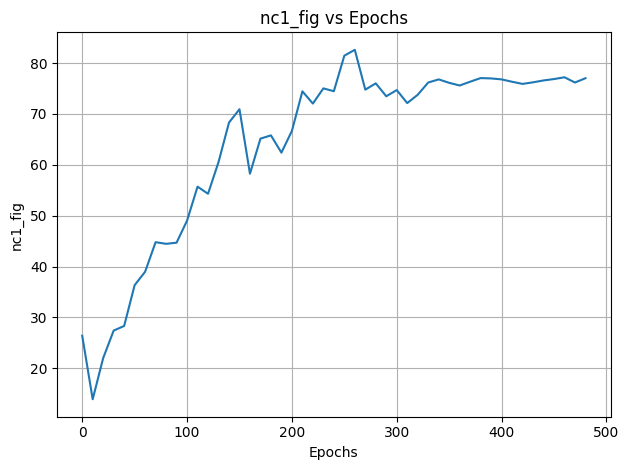

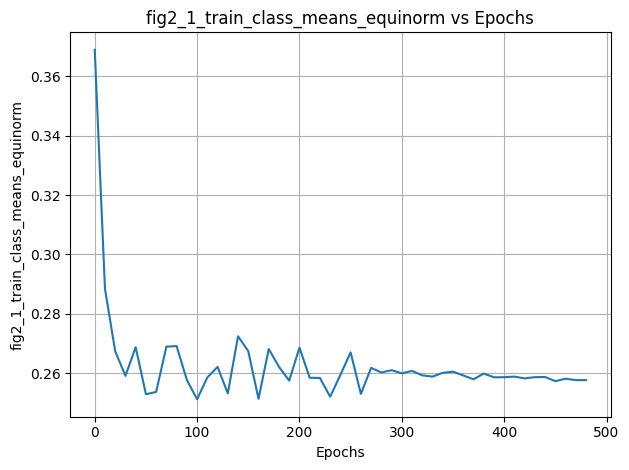

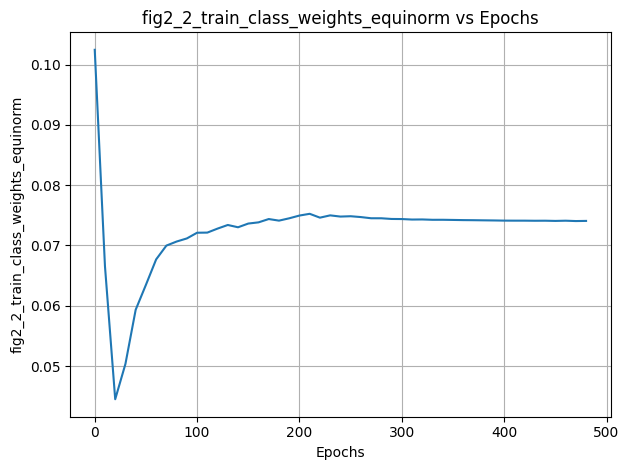

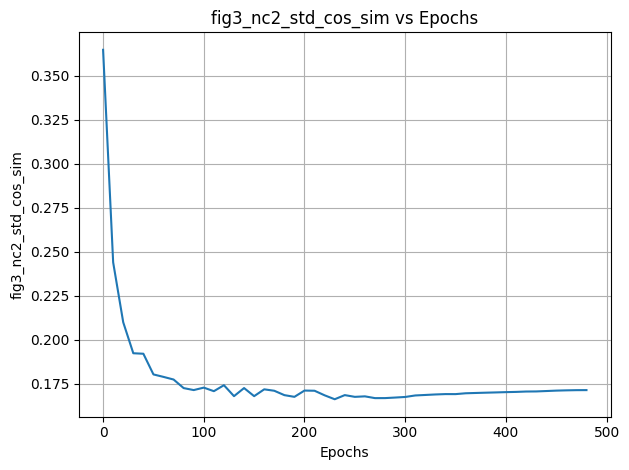

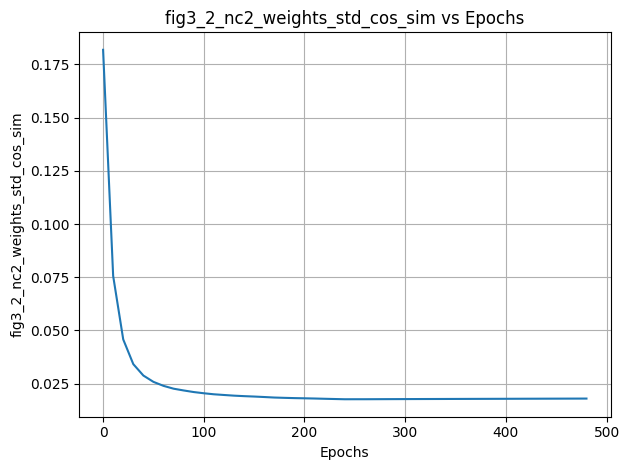

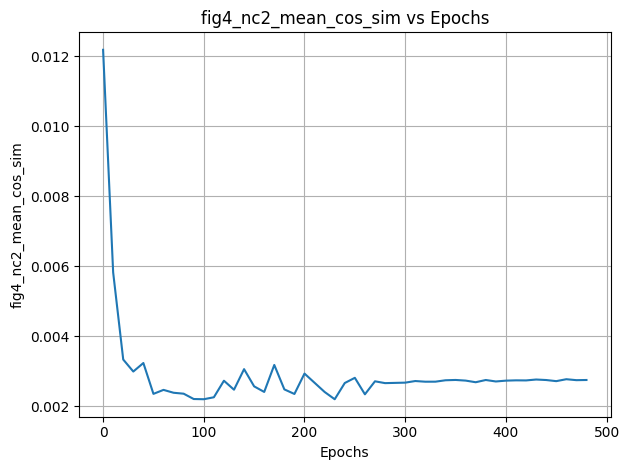

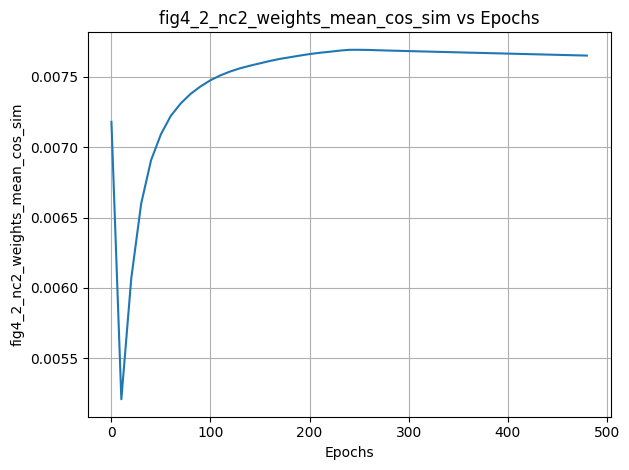

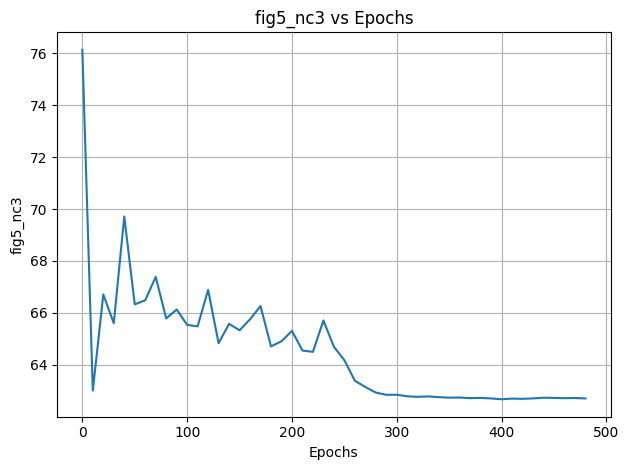

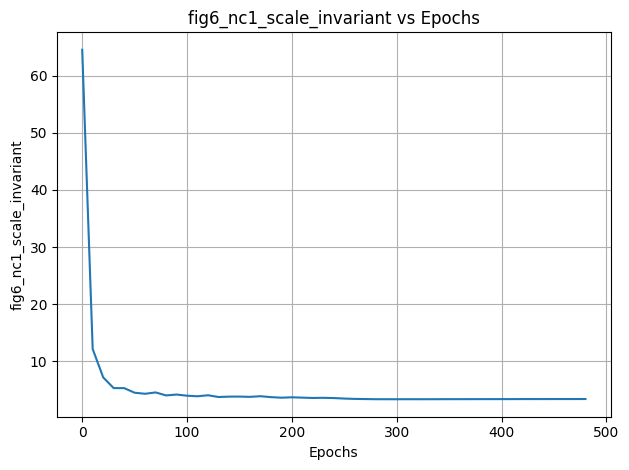

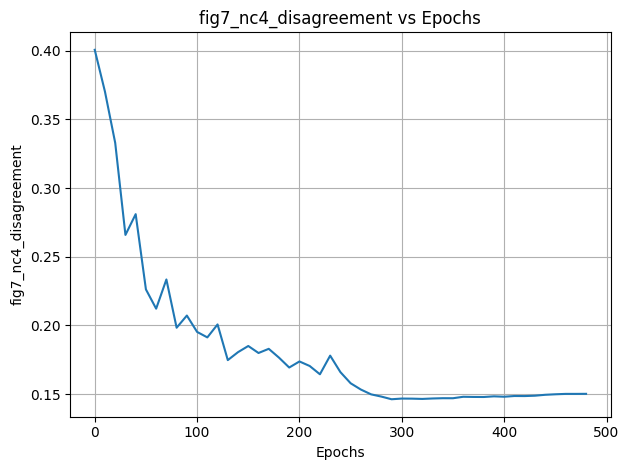

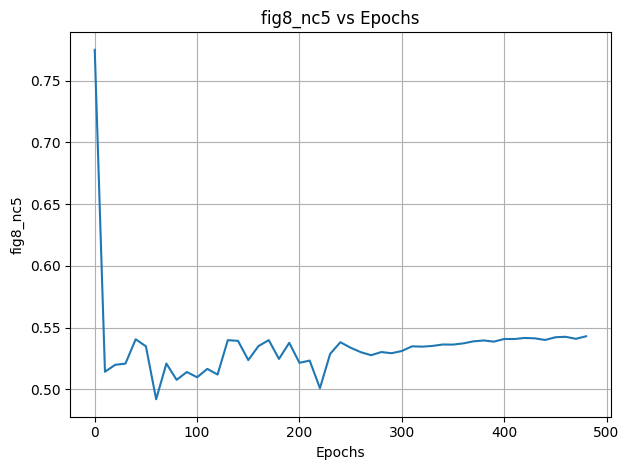

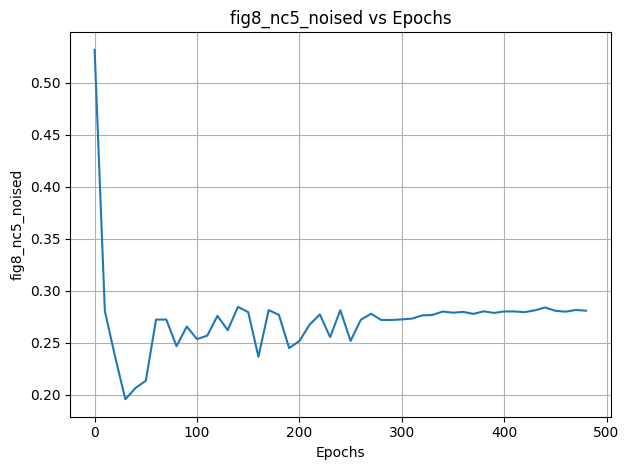

In [37]:
plot_nc_dataframe(df)

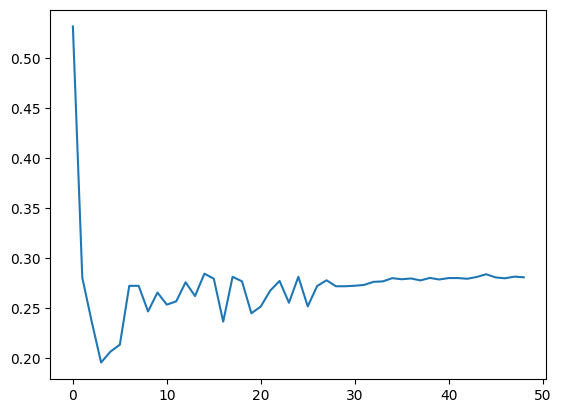

In [38]:
plt.plot(nc5_noised_fig)
plt.show()

In [39]:
def plot_nc_per_figure(df):
    if "epochs" not in df.columns:
        raise ValueError("DataFrame must contain an 'epochs' column.")

    epochs = df["epochs"]

    figures = {
        "Fig1_NC1": ["nc1_fig"],
        "Fig2_Equinorm": [
            "fig2_1_train_class_means_equinorm",
            "fig2_2_train_class_weights_equinorm"
        ],
        "Fig3_NC2_STD": [
            "fig3_nc2_std_cos_sim",
            "fig3_2_nc2_weights_std_cos_sim"
        ],
        "Fig4_NC2_MEAN": [
            "fig4_nc2_mean_cos_sim",
            "fig4_2_nc2_weights_mean_cos_sim"
        ],
        "Fig5_NC3": ["fig5_nc3"],
        "Fig6_NC1_ScaleInvariant": ["fig6_nc1_scale_invariant"],
        "Fig7_NC4": ["fig7_nc4_disagreement"],
        "Fig8_NC5": ["fig8_nc5"],
    }

    for title, cols in figures.items():
        existing = [c for c in cols if c in df.columns]
        if not existing:
            continue

        plt.figure()
        for col in existing:
            plt.plot(epochs, df[col], label=col)

        plt.xlabel("Epochs")
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        #save plt
        plt.savefig(f"{title}.png")
        plt.close()


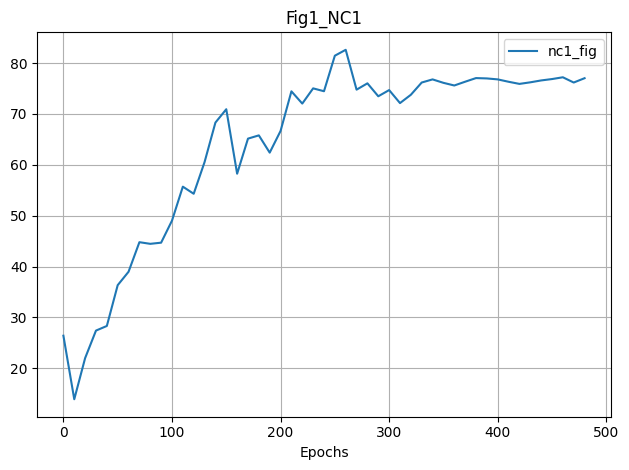

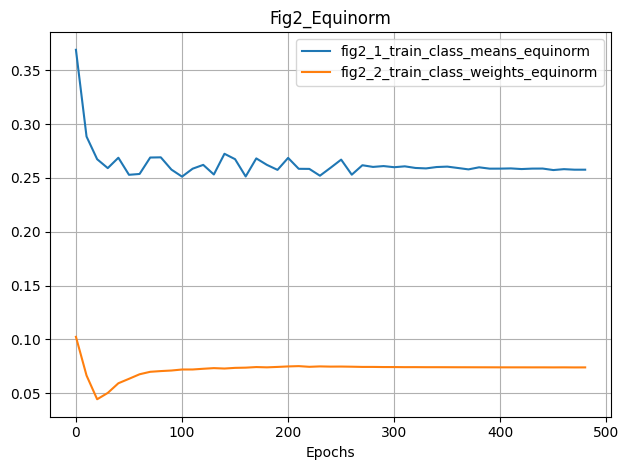

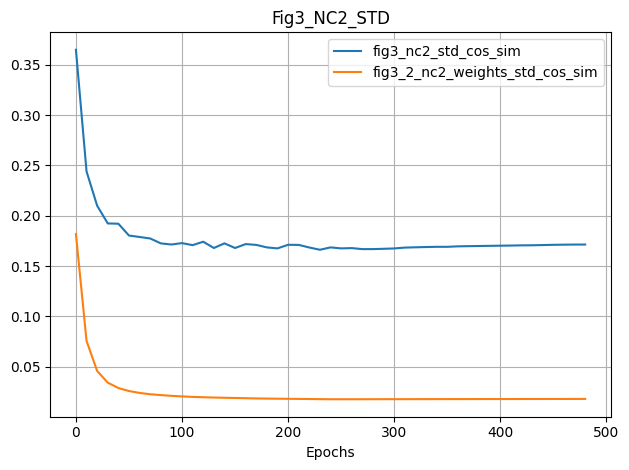

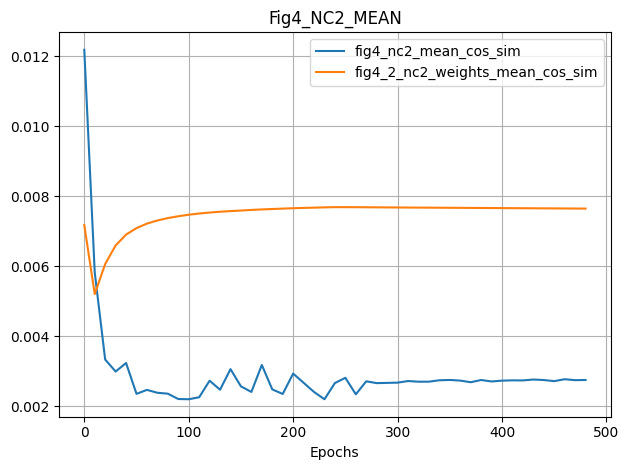

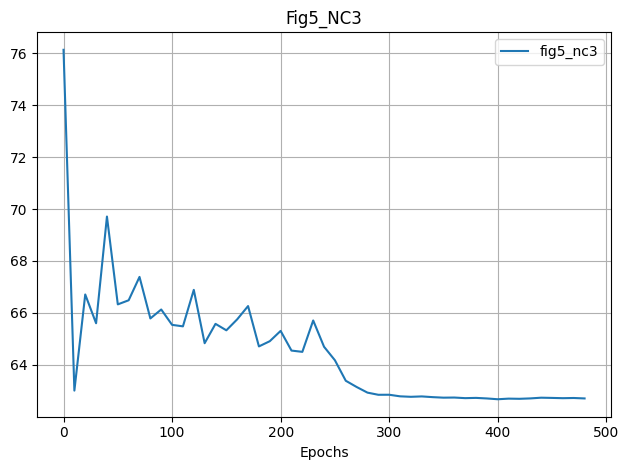

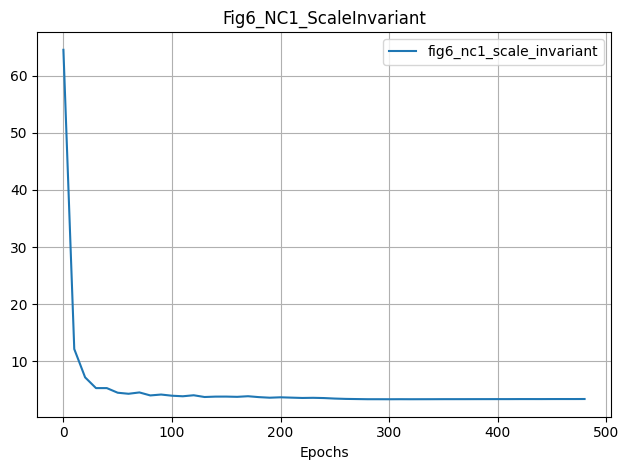

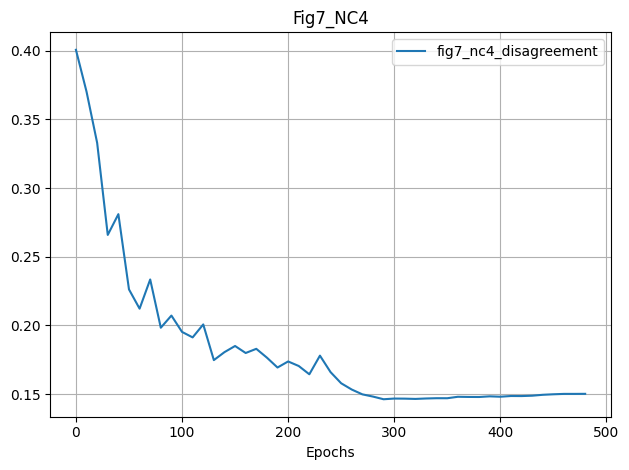

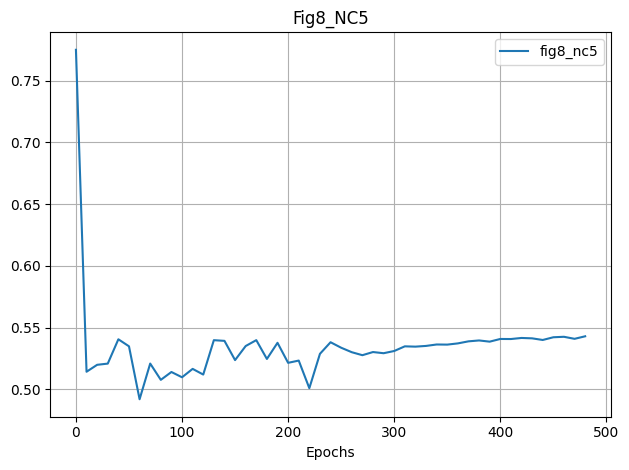

In [40]:
plot_nc_per_figure(df)


# NECO testing

In [ ]:
features.shape

In [ ]:
P = generate_P(features,360)

In [ ]:
resnet = load_model("./models/resnet_490_epoch.pth")

In [ ]:
t =torch.randn(1,3,32,32).to(device)
output = resnet.model(t)
output = output.T
n,_ = neco(P,output)
print("neco value :",n)
n,_ = neco_maxlogit(P,output)
print("neco max logit value :",n)